In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

读取数据，提取特征和目标变量

In [2]:
df = pd.read_csv('insurance.csv')
features = df[['age', 'bmi', 'children', 'smoker', 'region']]
target = df['charges']


In [3]:
features = features.copy()#复制一个数据副本

label_encoder = LabelEncoder()
features['smoker'] = label_encoder.fit_transform(features['smoker'])
features = pd.get_dummies(features, columns=['region'])

In [4]:
scaler = StandardScaler()
features[['age', 'bmi', 'children']] = scaler.fit_transform(features[['age', 'bmi', 'children']])

features = features.astype('float32')
target = target.astype('float32')

In [5]:
# 切分数据集
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
# 将数据转化为pytorch张量
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [7]:
# 定义模型架构
class FeedForwardModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.8):
        super(FeedForwardModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [8]:
# 设置模型参数
input_size = features.shape[1]
hidden_size1 = 64  
hidden_size2 = 32 
output_size = 1
dropout_rate = 0.8  

model = FeedForwardModel(input_size, hidden_size1, hidden_size2, output_size, dropout_rate)

# 设置损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.007)

num_epochs = 1000  
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    
    model.train()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

c:\Users\15017\.conda\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([936])) that is different to the input size (torch.Size([936, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\15017\.conda\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([201])) that is different to the input size (torch.Size([201, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/1000], Train Loss: 251083824.0000, Validation Loss: 223598944.0000
Epoch [200/1000], Train Loss: 185679296.0000, Validation Loss: 147254496.0000
Epoch [300/1000], Train Loss: 182868720.0000, Validation Loss: 144726192.0000
Epoch [400/1000], Train Loss: 182584832.0000, Validation Loss: 144314768.0000
Epoch [500/1000], Train Loss: 182203440.0000, Validation Loss: 144259264.0000
Epoch [600/1000], Train Loss: 181024784.0000, Validation Loss: 143865296.0000
Epoch [700/1000], Train Loss: 180930720.0000, Validation Loss: 144339504.0000
Epoch [800/1000], Train Loss: 180954352.0000, Validation Loss: 143830640.0000
Epoch [900/1000], Train Loss: 178935184.0000, Validation Loss: 144150864.0000
Epoch [1000/1000], Train Loss: 180107248.0000, Validation Loss: 143538528.0000


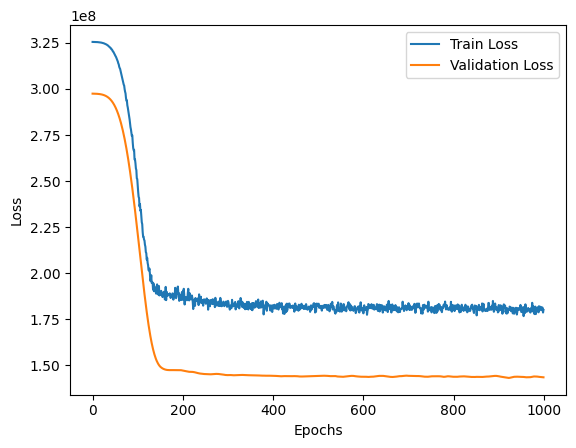

测试集的平均绝对误差: 8621.9580


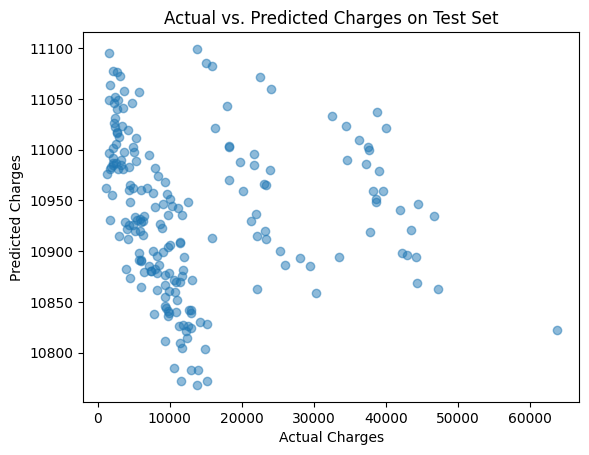

In [9]:

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    mae_test = mean_absolute_error(y_test_tensor.numpy(), test_predictions.numpy())
    print(f'测试集的平均绝对误差: {mae_test:.4f}')


plt.scatter(y_test_tensor.numpy(), test_predictions.numpy(), alpha=0.5)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs. Predicted Charges on Test Set')
plt.show()

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [11]:
# 将数据转换为PyTorch张量
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [12]:
# 定义线性回归模型架构
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# 设置输入大小和输出大小
input_size = features.shape[1]
output_size = 1

# 实例化模型
model = LinearRegressionModel(input_size, output_size)

# 设置损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [13]:
# 训练循环
num_epochs = 1000  # 根据需要调整
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # 前向传播和训练损失
    model.train()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

c:\Users\15017\.conda\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([936])) that is different to the input size (torch.Size([936, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\15017\.conda\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([201])) that is different to the input size (torch.Size([201, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/1000], Train Loss: 253694384.0000, Validation Loss: 230871280.0000
Epoch [200/1000], Train Loss: 210489920.0000, Validation Loss: 192124032.0000
Epoch [300/1000], Train Loss: 184809056.0000, Validation Loss: 169716800.0000
Epoch [400/1000], Train Loss: 169535840.0000, Validation Loss: 156877920.0000
Epoch [500/1000], Train Loss: 160444848.0000, Validation Loss: 149615600.0000
Epoch [600/1000], Train Loss: 155026928.0000, Validation Loss: 145582640.0000
Epoch [700/1000], Train Loss: 151791872.0000, Validation Loss: 143403344.0000
Epoch [800/1000], Train Loss: 149854608.0000, Validation Loss: 142275008.0000
Epoch [900/1000], Train Loss: 148689312.0000, Validation Loss: 141732128.0000
Epoch [1000/1000], Train Loss: 147983648.0000, Validation Loss: 141506928.0000


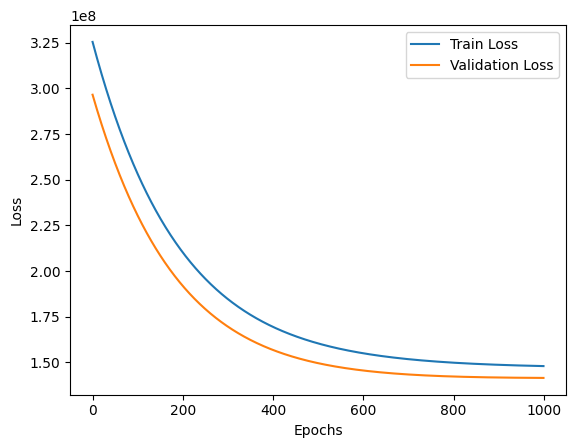

Mean Absolute Error on Test Set: 8484.3281


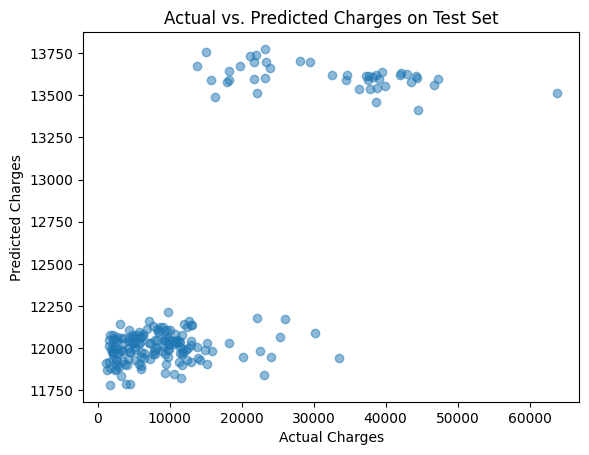

In [14]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    mae_test = mean_absolute_error(y_test_tensor.numpy(), test_predictions.numpy())
    print(f'Mean Absolute Error on Test Set: {mae_test:.4f}')

# 可视化结果
plt.scatter(y_test_tensor.numpy(), test_predictions.numpy(), alpha=0.5)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs. Predicted Charges on Test Set')
plt.show()

In [15]:
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [16]:
# 将数据转换为PyTorch张量
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [17]:
# 定义逻辑回归模型架构
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

# 设置输入大小和输出大小
input_size = features.shape[1]
output_size = 1  # 逻辑回归的输出大小通常为1，表示二分类的概率

# 实例化模型
model = LogisticRegressionModel(input_size, output_size)


In [18]:
# 训练循环
num_epochs = 1000  # 根据需要调整
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # 前向传播和训练损失
    model.train()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

c:\Users\15017\.conda\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([936])) that is different to the input size (torch.Size([936, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\15017\.conda\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([201])) that is different to the input size (torch.Size([201, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/1000], Train Loss: 325457760.0000, Validation Loss: 297406336.0000
Epoch [200/1000], Train Loss: 325457760.0000, Validation Loss: 297406336.0000
Epoch [300/1000], Train Loss: 325457760.0000, Validation Loss: 297406336.0000
Epoch [400/1000], Train Loss: 325457760.0000, Validation Loss: 297406336.0000
Epoch [500/1000], Train Loss: 325457760.0000, Validation Loss: 297406336.0000
Epoch [600/1000], Train Loss: 325457760.0000, Validation Loss: 297406336.0000
Epoch [700/1000], Train Loss: 325457760.0000, Validation Loss: 297406336.0000
Epoch [800/1000], Train Loss: 325457760.0000, Validation Loss: 297406336.0000
Epoch [900/1000], Train Loss: 325457760.0000, Validation Loss: 297406336.0000
Epoch [1000/1000], Train Loss: 325457760.0000, Validation Loss: 297406336.0000


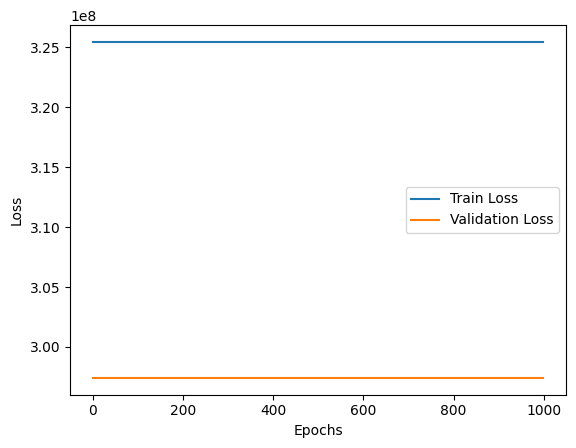

Mean Absolute Error on Test Set: 13530.2012


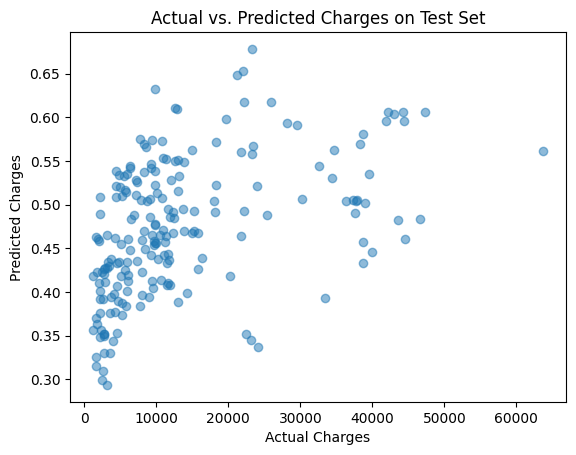

In [19]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    mae_test = mean_absolute_error(y_test_tensor.numpy(), test_predictions.numpy())
    print(f'Mean Absolute Error on Test Set: {mae_test:.4f}')

# 可视化结果
plt.scatter(y_test_tensor.numpy(), test_predictions.numpy(), alpha=0.5)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs. Predicted Charges on Test Set')
plt.show()

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


In [21]:

X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 将数据转换为PyTorch张量
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


In [22]:
# 定义MLP模型架构
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# 设置输入大小、隐藏层大小和输出大小
input_size = features.shape[1]
hidden_size1 = 64  # 根据需要调整
hidden_size2 = 32  # 根据需要调整
output_size = 1    # 根据需要调整

# 实例化模型
model = MLPModel(input_size, hidden_size1, hidden_size2, output_size)

# 设置损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.006)

In [23]:
# 训练循环
num_epochs = 1000  # 根据需要调整
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # 前向传播和训练损失
    model.train()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 验证损失
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # 保存损失以供绘图
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # 打印训练信息
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')



c:\Users\15017\.conda\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([936])) that is different to the input size (torch.Size([936, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\15017\.conda\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([201])) that is different to the input size (torch.Size([201, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/1000], Train Loss: 278417248.0000, Validation Loss: 253201792.0000
Epoch [200/1000], Train Loss: 150246256.0000, Validation Loss: 144597232.0000
Epoch [300/1000], Train Loss: 147879728.0000, Validation Loss: 142804992.0000
Epoch [400/1000], Train Loss: 147077520.0000, Validation Loss: 142229168.0000
Epoch [500/1000], Train Loss: 146757040.0000, Validation Loss: 142020160.0000
Epoch [600/1000], Train Loss: 146623024.0000, Validation Loss: 141941760.0000
Epoch [700/1000], Train Loss: 146559536.0000, Validation Loss: 141904032.0000
Epoch [800/1000], Train Loss: 146525216.0000, Validation Loss: 141879040.0000
Epoch [900/1000], Train Loss: 146505120.0000, Validation Loss: 141863632.0000
Epoch [1000/1000], Train Loss: 146492944.0000, Validation Loss: 141853872.0000


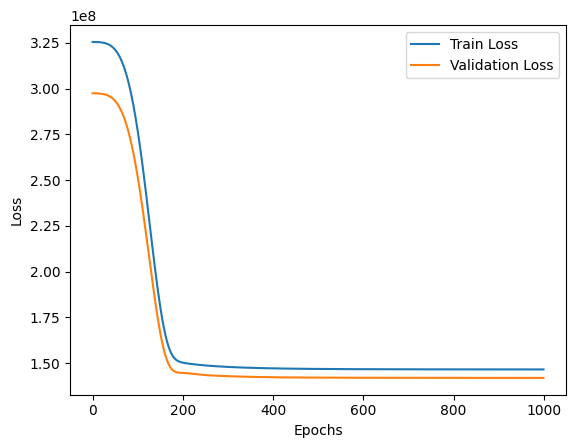

Mean Absolute Error on Test Set: 9305.9053


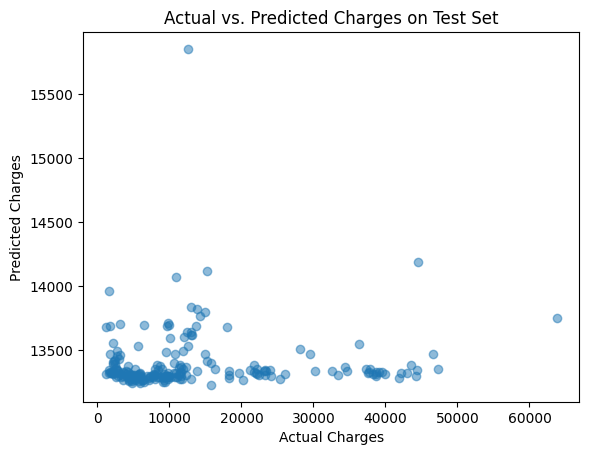

In [24]:
# 绘制训练和验证损失
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 在测试集上评估模型
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    mae_test = mean_absolute_error(y_test_tensor.numpy(), test_predictions.numpy())
    print(f'Mean Absolute Error on Test Set: {mae_test:.4f}')

# 可视化结果
plt.scatter(y_test_tensor.numpy(), test_predictions.numpy(), alpha=0.5)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs. Predicted Charges on Test Set')
plt.show()